Please note that the file libdevice.10.bc is only in the Titanic folder as a workaround to a bug. The file is not automatically found at its proper location (/usr/lib/cuda/nvvm/libdevice/libdevice.10.bc) so it is placed here instead.

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [70]:
# Have a look at the data
train = pd.read_csv("train.csv")
train = train.sample(frac=1)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
680,681,0,3,"Peters, Miss. Katie",female,NaN,0,0,330935,8.1375,NaN,Q
446,447,1,2,"Mellinger, Miss. Madeleine Violet",female,13.0,0,1,250644,19.5000,NaN,S
537,538,1,1,"LeRoy, Miss. Bertha",female,30.0,0,0,PC 17761,106.4250,NaN,C
799,800,0,3,"Van Impe, Mrs. Jean Baptiste (Rosalie Paula Go...",female,30.0,1,1,345773,24.1500,NaN,S
267,268,1,3,"Persson, Mr. Ernst Ulrik",male,25.0,1,0,347083,7.7750,NaN,S


In [71]:
def normalise_age_and_fare(df: pd.DataFrame) -> pd.DataFrame: # Takes in the training dataframe and returns the same dataframe with the Age and Fare columns normalised and NaN entries filled.
    
    # Normalise the Age and Fare columns
    df.Age = (df.Age - df.Age.mean()) / df.Age.std()
    df.Fare = (df.Fare - df.Fare.mean()) / df.Fare.std()
    
    # Replace null age values with a random number sampled from the uniform distribution over [-1, +1] (this is mean +/- std of the ages)
    null_ages = np.isnan(df.Age)
    null_ages_count = len(null_ages)
    random_ages = np.random.random_sample(null_ages_count)
    random_ages = (random_ages - 0.5) * 2
    df.Age[null_ages] = random_ages
    
    return df

In [72]:
def add_NaN_count(df: pd.DataFrame): # Takes in dataframe, returns same dataframe with the new column "NaN_count" describing how many of the other columns are NaN for each passenger.
    filled_column_count = df.count(axis=1) # This calculates how many columns are filled with some value for each passenger
    number_of_columns = len(df.columns)
    NaN_count = number_of_columns - filled_column_count
    df.insert(0, "NaN_count", NaN_count.values, True)
    return df

In [73]:
def preprocess_df(df: pd.DataFrame): # For training set, returns a cleaned training dataset as well as labels in their own dataframe. For test set, returns only cleaned dataset.
        
    # Remove categories that don't correspond to survival rate.
    df = df.drop("PassengerId", axis=1)
    df = df.drop("Name", axis=1)
    df = df.drop("Ticket", axis=1)
    df = df.drop("Cabin", axis=1)
    
    # Add feature describing how many values are NaN for each passenger.
    df = add_NaN_count(df)
    
    # Map female -> 0 and male -> 1
    df["Sex"] = df["Sex"].map({"female": 0,
                               "male": 1})

    # In "Embarked" column there are {S:644, C:168, Q:77, NaN:2} so we map S -> 0, C -> 1, Q -> 2, NaN -> 0
    embarked_map = {"S": 0,
                    "C": 1,
                    "Q": 2}

    df["Embarked"] = df["Embarked"].map(embarked_map)
    df.Embarked = df.Embarked.fillna(0)
    
    # Normalise Age and Fare columns
    df = normalise_age_and_fare(df)
    
    return df

In [74]:
def build_model(): # Returns a compiled model, as K-fold cross validation involves building the same model lots of times
    
    model = keras.Sequential([
        layers.Dense(32, activation="relu"),
        layers.Dense(32, activation="relu"),
        layers.Dense(32, activation="relu"),
        layers.Dense(1, activation="sigmoid")
    ])

    model.compile(
        optimizer=keras.optimizers.RMSprop(0.01),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    
    return model

In [75]:
def k_fold_validation(k, num_epochs, df): # Trains model for one round of k-fold validation
    
    shuffled_df = df.sample(frac=1)
    labels = shuffled_df.pop("Survived")
    train = shuffled_df
    num_val_samples = len(train) // k
    all_histories = []
    
    for i in range(k):
        #print(f"Processing fold #{i}")
        
        val_data = train[i * num_val_samples: (i + 1) * num_val_samples]
        val_labels = labels[i * num_val_samples: (i + 1) * num_val_samples]
        
        partial_train_data = np.concatenate(
            [train[:i * num_val_samples],
            train[(i + 1) * num_val_samples:]],
            axis=0
        )
        
        partial_train_labels = np.concatenate(
            [labels[:i * num_val_samples],
            labels[(i + 1) * num_val_samples:]],
            axis=0
        )
        
        model = build_model()
        
        history = model.fit(
            partial_train_data,
            partial_train_labels,
            epochs=num_epochs,
            validation_data=(val_data, val_labels),
            verbose=0
        )
        
        all_histories.append(history)
        
    # Average the training and validation accuracy for each epoch across the folds
    single_iter_val_accuracy = np.empty((k,num_epochs))
    single_iter_train_accuracy = np.empty((k,num_epochs))
    for i in range(k):
        single_iter_val_accuracy[i,:] = all_histories[i].history["val_accuracy"]
        single_iter_train_accuracy[i,:] = all_histories[i].history["accuracy"]
    single_iter_val_accuracy = single_iter_val_accuracy.mean(axis=0)
    single_iter_train_accuracy = single_iter_train_accuracy.mean(axis=0)
    
    return single_iter_val_accuracy, single_iter_train_accuracy
    

In [76]:
# Does iterated k-fold validation. Averages the training and validation accuracy for each epoch across the iterations.

df = pd.read_csv("train.csv")
df = preprocess_df(df)

k = 5 # This value seems to work fine
num_epochs = 40 # When testing new models, set this high enough to see overfitting (assuming model is powerful enough to overfit)
iterations = 10 # If accuracy scores have high variance, increase iterations to 5 (smoother) or 10 (smoothest)
avg_train_accuracy = np.empty((iterations,num_epochs))
avg_val_accuracy = np.empty((iterations,num_epochs))

for i in range(iterations):
    print(f"Processing iteration #{i}")
    single_iter_val_accuracy, single_iter_train_accuracy = k_fold_validation(k, num_epochs, df)
    avg_val_accuracy[i,:] = single_iter_val_accuracy
    avg_train_accuracy[i,:] = single_iter_train_accuracy
avg_val_accuracy = avg_val_accuracy.mean(axis=0)
avg_train_accuracy = avg_train_accuracy.mean(axis=0)

/tmp/ipykernel_858/3999765340.py:12: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df.Age[null_ages] = random_ages
/tmp/ipykernel_858/3999765340.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

Processing iteration #0
Processing iteration #1
Processing iteration #2


2024-08-16 19:17:04.280280: E external/local_xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module a_inference_one_step_on_data_1364433__.544] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2024-08-16 19:18:30.684703: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 3m26.410727695s

********************************
[Compiling module a_inference_one_step_on_data_1364433__.544] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


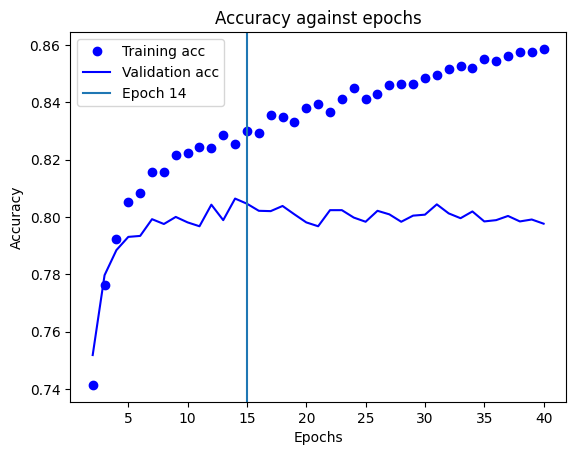

In [68]:
# Plot training and validation accuracy for each epoch

cut = 1 # This removes first epoch (usually very incorrect) to help the graph scale correctly
epochs = range(cut+1, num_epochs + 1)
plt.plot(epochs, avg_train_accuracy[cut:], "bo", label="Training acc")
plt.plot(epochs, avg_val_accuracy[cut:], "b", label="Validation acc")
plt.axvline(15, label="Epoch 14")
plt.title("Accuracy against epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
#plt.savefig("good fitting info.png")
plt.show()

In [31]:
# Building and training a new model from scratch, using all data, for generating predictions

df = pd.read_csv("train.csv")
df = preprocess_df(df)
labels = df.pop("Survived")
train = df

model = build_model()
        
history = model.fit(
    train,
    labels,
    epochs=15, # Change this depending on when the model starts overfitting
    verbose=0
)

/tmp/ipykernel_858/3999765340.py:12: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df.Age[null_ages] = random_ages
/tmp/ipykernel_858/3999765340.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

In [32]:
# Generate predictions and send them to a .csv file

test = pd.read_csv("test.csv")
PassengerId = test["PassengerId"].values
test = preprocess_df(test)
predictions = model.predict(test)

# Convert all predictions to 0 or 1
for i in range(len(predictions)):
    if predictions[i] < 0.5:
        predictions[i] = 0
    else:
        predictions[i] = 1

predictions = predictions.astype(int) # The submission format requires integers.
predictions = predictions.flatten() # This turns predictions into a 1D array that can be put into a dataframe.
        
data = {'PassengerId': PassengerId,
        'Survived': predictions}

prediction_df = pd.DataFrame(data)
prediction_df.to_csv("predictions.csv", index=False)

 1/14 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step

/tmp/ipykernel_858/3999765340.py:12: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df.Age[null_ages] = random_ages
/tmp/ipykernel_858/3999765340.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
